In [2]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, rand_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from umap import UMAP
import plotly.express as px
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import LabelEncoder

In [3]:
male_players_24 = pd.read_csv("male_players_preprocessed.csv")

In [4]:
#here are the relevant features that we will use in our clustering
keeping_features = [
       'attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing',
       'attacking_volleys', 'skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
       'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power',
       'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
       'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision',
        'defending_marking_awareness',
       'defending_standing_tackle', 'defending_sliding_tackle',
       'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking',
       'goalkeeping_positioning', 'goalkeeping_reflexes', 'ls', 'st', 'rs',
       'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm',
       'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb',
       'rcb', 'rb', 'gk']

X = male_players_24[keeping_features]

# compare the ground truth for metrics
true_labels = male_players_24['broad_position']

In [5]:
len(keeping_features)

59

In [7]:
# check the range to see if we need standardization
min_value = X.min().min()
max_value = X.max().max()

print("Minimum value in X:", min_value)
print("Maximum value in X:", max_value)

Minimum value in X: 2
Maximum value in X: 97


In [8]:
# we don't need to standardize the values since the range is 0-100
# X_scaled = StandardScaler().fit_transform(X)
# X_scaled is not scaled actually
X_scaled = X.copy()

### PCA

In [9]:
pca = PCA(n_components=0.90) # setting threshold to 90%
X_pca = pca.fit_transform(X_scaled)

In [10]:
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Total variance explained by all selected components:", sum(pca.explained_variance_ratio_))

Explained variance ratio: [0.67850301 0.16480112 0.04595538 0.03210933]
Total variance explained by all selected components: 0.9213688512713296


The explained variance ratio is a metric that tells you how much of the total variance in your dataset is captured by each principal component generated by PCA (Principal Component Analysis). Specifically, it indicates the proportion of the dataset's variance that lies along each principal component axis.

The first principal component captures approximately 67.85% of the variance in the dataset, second principal component, 0.16%, and so on. This means that a significant portion of the information (or variability) in your dataset can be represented along this first principal component dimension.

Text(0.5, 1.0, 'PCA Projection - First Two Principal Components')

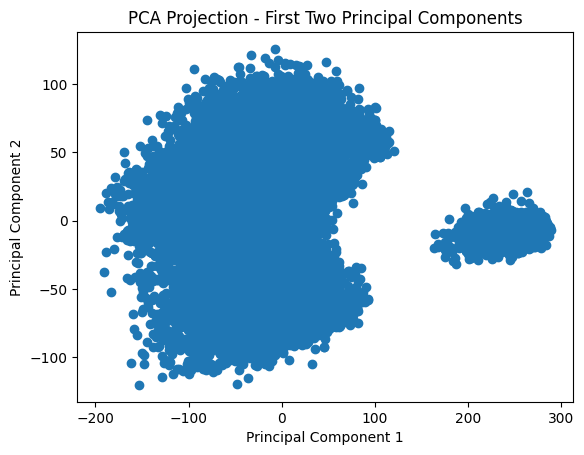

In [11]:
# scatter plot the pc1 and pc2
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Projection - First Two Principal Components')

Text(0, 0.5, 'PC 2')

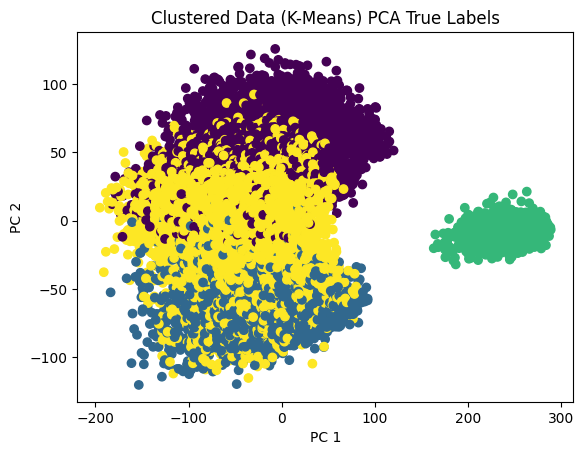

In [12]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(true_labels)

# true label for pca scatter plot
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_encoded)
plt.title('Clustered Data (K-Means) PCA True Labels')
plt.xlabel('PC 1')
plt.ylabel('PC 2')

The above scatter plot is not enough to do the dimensionality reduction for 4 ground truth positions.  We can only observe 2 clusters and the small cluster will be goal keeper and the big cluster most likely contain the other 3 positions.

Now do another dimensionality reduction approach.

### UMAP

In [13]:
umap = UMAP(n_neighbors=10, min_dist=0.99, n_components=2) # find the right parameter

# Fit UMAP and transform your data
X_umap = umap.fit_transform(X_scaled)

Text(0, 0.5, 'UMAP Component 2')

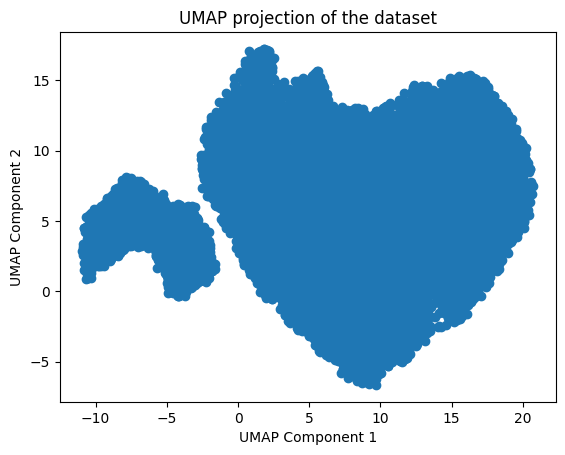

In [14]:
plt.scatter(X_umap[:, 0], X_umap[:, 1])
plt.title('UMAP projection of the dataset')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')

Text(0, 0.5, 'Component 2')

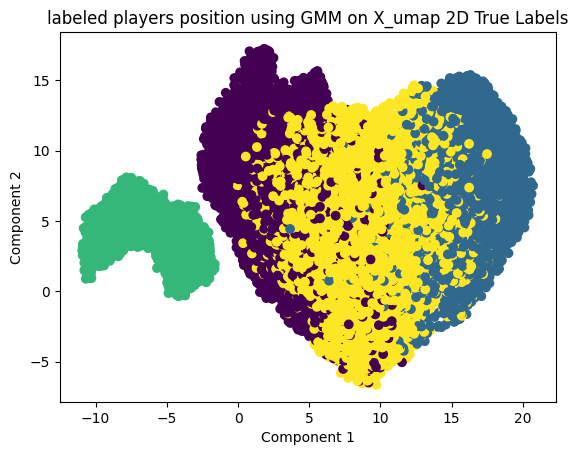

In [18]:
# True labels 2D GMMs
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=labels_encoded)
plt.title('labeled players position using GMM on X_umap 2D True Labels')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

Since trying with multiple parameters doesn't separate the exact 4 clusters, try the 3d versions with n_components=3

In [ ]:
umap_3d = UMAP(n_neighbors=10, min_dist=0.99, n_components=3) # # find the right parameter

# Fit UMAP and transform your data
X_umap_3d = umap_3d.fit_transform(X_scaled)

In [ ]:
fig = px.scatter_3d(
    x=X_umap_3d[:, 0],
    y=X_umap_3d[:, 1],
    z=X_umap_3d[:, 2],
    title='3D UMAP projection of the dataset'
)

fig.update_layout(
    scene=dict(
        xaxis_title='UMAP Component 1',
        yaxis_title='UMAP Component 2',
        zaxis_title='UMAP Component 3'
    )
)

In [ ]:
# plot the true label in 3d
fig = px.scatter_3d(
    x=X_umap_3d[:, 0],
    y=X_umap_3d[:, 1],
    z=X_umap_3d[:, 2],
    color=true_labels,
    title='3D UMAP Projection of the Dataset (Colored by True Labels)'
)

fig.update_layout(
    scene=dict(
        xaxis_title='UMAP Component 1',
        yaxis_title='UMAP Component 2',
        zaxis_title='UMAP Component 3'
    ),
    margin=dict(l=0, r=0, b=0, t=0)
)

### t-SNE

In [19]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)  # Setting random_state for reproducibility
X_tsne = tsne.fit_transform(X)

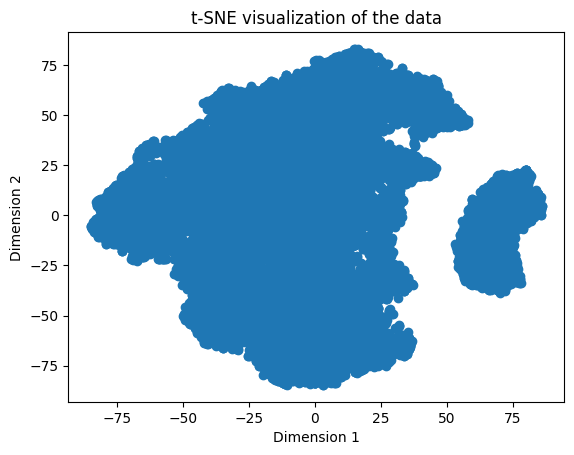

In [ ]:
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])  # Plotting the two dimensions
plt.title('t-SNE visualization of the data')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

In [ ]:
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels_encoded)  # Plotting the two dimensions
plt.title('t-SNE visualization of the data')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

In [ ]:
tsne3d = TSNE(n_components=3, random_state=42)  # Setting random_state for reproducibility
X_tsne_3d = tsne3d.fit_transform(X)

In [ ]:
fig = px.scatter_3d(
    x=X_tsne_3d[:, 0],
    y=X_tsne_3d[:, 1],
    z=X_tsne_3d[:, 2],
     color=true_labels,
    title='3D t-SNE projection of the dataset'
)

fig.update_layout(
    scene=dict(
        xaxis_title='UMAP Component 1',
        yaxis_title='UMAP Component 2',
        zaxis_title='UMAP Component 3'
    )
)

## Clustering from here

### K means


In [ ]:
kmeans = KMeans(n_clusters=4)
cluster_labels_k = kmeans.fit_predict(X_umap)
cluster_labels_k

array([3, 3, 3, ..., 2, 1, 1])

In [ ]:
# scatter plot of the predicted clustered using k means using pca structure
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels_k)
plt.title('Clustered Data (K-Means) PCA')
plt.xlabel('PC 1')
plt.ylabel('PC 2')

In [ ]:
# calculate metrics 
silhouette_avg_k_pca = silhouette_score(X_pca, cluster_labels_k)
print(f'Silhouette Score K means using PCA dataset: {silhouette_avg_k_pca:.2f}')
ari_k = adjusted_rand_score(true_labels, cluster_labels_k)
print(f'Adjusted Rand Index: {ari_k:.2f}')

Text(0, 0.5, 'Component 2')

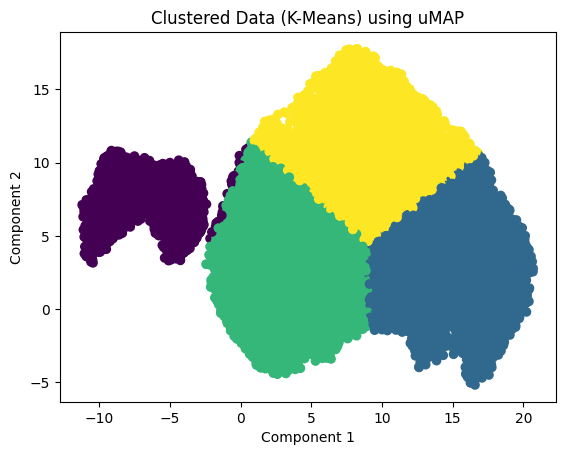

In [ ]:
# using X_umap scatter plot of the predicted k-means clustered
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=cluster_labels_k)
plt.title('Clustered Data (K-Means) using uMAP')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

In [ ]:
# calculate metrics 
silhouette_avg_umap = silhouette_score(X_umap, cluster_labels_k)
print(f'Silhouette Score U-MAP means: {silhouette_avg_umap:.2f}')
ari_k = adjusted_rand_score(true_labels, cluster_labels_k)
print(f'Adjusted Rand Index: {ari_k:.2f}')

Silhouette Score K means: 0.44
Adjusted Rand Index: 0.39


Text(0, 0.5, 'PC 2')

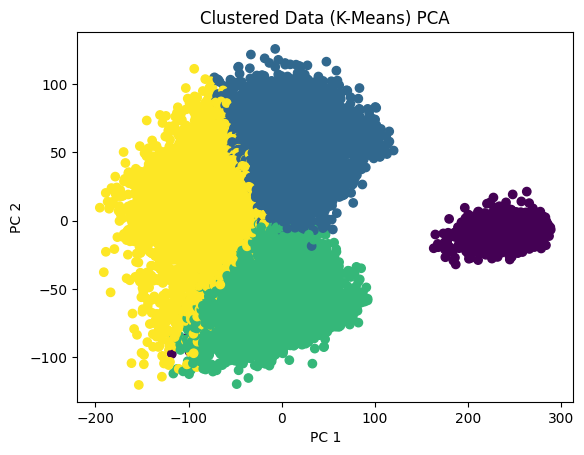

Silhouette Score K means using PCA dataset: 0.42
Adjusted Rand Index: 0.39


### Gaussian Mixture Model

In [ ]:
# Grid Search
# could implement cross validation here
param_grid = {
    'n_components': [4], 
    'covariance_type': ['full', 'tied', 'diag', 'spherical'],
    'tol': [0.001, 0.01], 
    'n_init': [1,2],
    'init_params': ['kmeans', 'random'], 
}

best_ari_2d = -1
best_ari_3d = -1
best_params_2d = {}
best_params_3d = {}

for params in ParameterGrid(param_grid):
    gmm = GaussianMixture(random_state=42, **params)
    labels_2d = gmm.fit_predict(X_umap)
    labels_3d = gmm.fit_predict(X_umap_3d)
    ari_2d = adjusted_rand_score(true_labels, labels_2d)  # Assuming true_labels are available
    ari_3d = adjusted_rand_score(true_labels, labels_3d)  # Assuming true_labels are available

    if ari_2d > best_ari_2d:
        best_ari_2d = ari_2d
        best_params_2d = params
    
    if ari_3d > best_ari_3d:
        best_ari_3d = ari_3d
        best_params_3d = params

print("Best Parameters 2d:", best_params_2d)
print("Best Parameters 3d:", best_params_3d)

Best Parameters 2d: {'covariance_type': 'diag', 'init_params': 'kmeans', 'n_components': 4, 'n_init': 1, 'tol': 0.001}
Best Parameters 3d: {'covariance_type': 'full', 'init_params': 'kmeans', 'n_components': 4, 'n_init': 1, 'tol': 0.001}


In [ ]:
gmm = GaussianMixture(**best_params_2d)
cluster_labels_gmm = gmm.fit_predict(X_umap)
cluster_labels_gmm

array([0, 0, 3, ..., 0, 1, 1], dtype=int64)

Text(0, 0.5, 'Component 2')

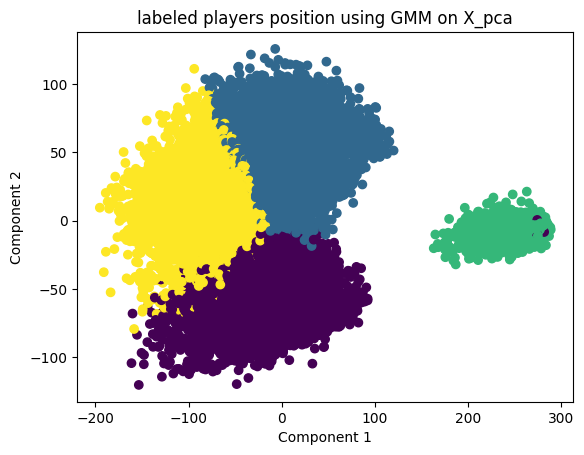

In [ ]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels_gmm)
plt.title('labeled players position using GMM on X_pca')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

In [ ]:
# calculate metrics 
silhouette_avg_gmm_pca = silhouette_score(X_pca, cluster_labels_gmm)
print(f'Silhouette Score (GMM) using X_pca: {silhouette_avg_gmm_pca:.2f}')

ari_gmm = adjusted_rand_score(true_labels, cluster_labels_gmm)
print(f'Adjusted Rand Index (GMM): {ari_gmm:.2f}')

Silhouette Score (GMM) using X_pca: 0.41
Adjusted Rand Index (GMM): 0.40


Text(0, 0.5, 'Component 2')

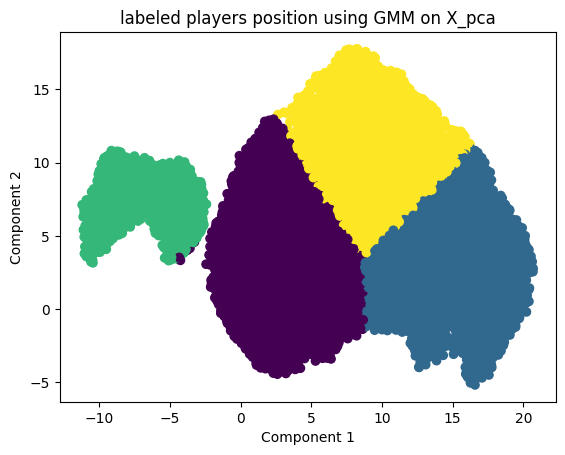

In [ ]:
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=cluster_labels_gmm)
plt.title('labeled players position using GMM on X_umap')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

Text(0, 0.5, 'Component 2')

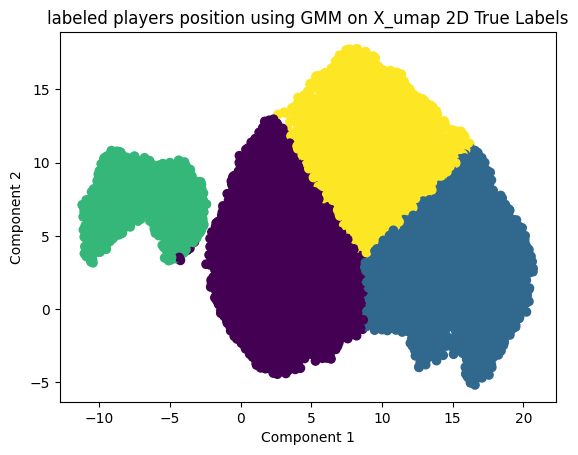

In [ ]:
# True labels 2D GMMs
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=cluster_labels_gmm)
plt.title('labeled players position using GMM on X_umap 2D True Labels')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

In [ ]:
# calculate metrics 
silhouette_avg_gmm = silhouette_score(X_umap, cluster_labels_gmm)
print(f'Silhouette Score (GMM): {silhouette_avg_gmm:.2f}')

ari_gmm = adjusted_rand_score(true_labels, cluster_labels_gmm)
print(f'Adjusted Rand Index (GMM): {ari_gmm:.2f}')

Silhouette Score (GMM): 0.43
Adjusted Rand Index (GMM): 0.40


In [ ]:
# 3D GMM
gmm_3d = GaussianMixture(**best_params_3d)
cluster_labels_gmm_3d = gmm_3d.fit_predict(X_umap_3d)
cluster_labels_gmm_3d

array([1, 1, 2, ..., 1, 0, 0], dtype=int64)

In [ ]:
# 3D scatter plot for cluster_labels_gmm
fig = px.scatter_3d(
    x=X_umap_3d[:, 0],
    y=X_umap_3d[:, 1],
    z=X_umap_3d[:, 2],
    color=cluster_labels_gmm_3d,  # Color points by GMM cluster label
    title='3D UMAP Projection of the Dataset (Colored by GMM Clusters)'
)

fig.update_layout(
    scene=dict(
        xaxis_title='UMAP Component 1',
        yaxis_title='UMAP Component 2',
        zaxis_title='UMAP Component 3'
    ),
    margin=dict(l=0, r=0, b=0, t=0)
)

In [ ]:
# calculate metrics 
silhouette_avg_3d = silhouette_score(X_umap_3d, cluster_labels_gmm)
print(f'Silhouette Score (GMM on 3D UMAP): {silhouette_avg_3d:.2f}')

# adjusted rand index is same as 2d
ari_3d = adjusted_rand_score(true_labels, cluster_labels_gmm)
print(f'Adjusted Rand Index (GMM on 3D UMAP): {ari_3d:.2f}')

Silhouette Score (GMM on 3D UMAP): 0.40
Adjusted Rand Index (GMM on 3D UMAP): 0.40


M, F looks very mixed. It is hard to distinguish because there are many overlapping stats for positions M, F.

what can we do?
- select better features that can distinguish the most out of all positions

In [ ]:
raise Exception('harry work till here')

Exception: harry work till here

### End of Harry's section
---